# Speech recognition with CTC-loss

Automatic Speech Recognition(ASR), or speech to text(STT). It's convenient to use STT since the name encodes that we are solving an inverse TTS problem.

#### Task definition:

Given dataset $D = \{ (\mathbf{x}^{(i)}, \mathbf{y}^{(i)}) \}_{i=1}^{N}$ where $\mathbf{x}^{(i)} = [x_1, x_2, ... x_{T}]$ - represents audio clip of length $T$ and $\mathbf{y}^{(i)} = [y_1, y_2, ... y_{C}]$ is a corresponding text sequence of length $C$ we need to find a mapping between each audio frame with corresponding character/token. This mapping is defined via alignment
 $$ 
A  = \begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1T} \\ a_{21} & a_{22} & \cdots & a_{2T} \\ \vdots & \vdots & \ddots & \vdots \\ a_{C1} & a_{C2} & \cdots & a_{CT} \end{bmatrix} , A \in \mathbb{R}^{C \times T} $$


Typicaly we don't have precise information about alignment, we only have pairs of audio clips and corresponding texts. In other words we don't know when each token was pronounced. CTC algorithms overcomes this issue, for a given $\mathbf{x}$ it gives us a distribution of all possible $\mathbf{y}'s$

Also we introduce an augmented sequence $\mathbf{z} = [\epsilon, y_{1}, \epsilon, y_{2}, ... \epsilon, y_{C},]$ that allows us to model arbitrary durations for all tokens in $\mathbf{y}$. Where $\epsilon$ signals transition to next token in $y$ sequence.
and a neural network with parameters $\theta$ we want to predict text tokens given input audio. $P(y|x;\theta)$

In [1]:
import orjson
import torch
import torch.nn as nn
import soundfile as sf
from pathlib import Path
import random
import numpy as np
from IPython.display import display, Audio
import torchaudio

In [2]:
def read_manifest(manifest_path):
    res = []
    with open(manifest_path, 'rb') as f:
        for line in f:
            data = orjson.loads(line)
            res.append(data)
        return res

def get_num_params(model: nn.Module):
    n_params = sum([p.numel() for p in model.parameters()])
    return n_params

# STT example. Citrinet.


Model's architecture: 1D separable convolution CTC model, with explicit modeling dependencies between channels with help of Squeeze-Excitation(SE) layers.



In [3]:
from nemo.collections.asr.models import EncDecCTCModel

In [4]:
asr_model_cfg = EncDecCTCModel.from_pretrained("nvidia/stt_uk_citrinet_1024_gamma_0_25", return_config=True)

In [5]:
dict(asr_model_cfg)

{'sample_rate': 16000,
 'log_prediction': True,
 'train_ds': {'manifest_filepath': '/data/all_train_data_new.json', 'sample_rate': 16000, 'batch_size': 16, 'trim_silence': False, 'max_duration': 20.0, 'shuffle': True, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None},
 'validation_ds': {'manifest_filepath': '/data/dev_new.json', 'sample_rate': 16000, 'batch_size': 16, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True},
 'test_ds': {'manifest_filepath': '/data/test_new.json', 'sample_rate': 16000, 'batch_size': 16, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True},
 'model_defaults': {'repeat': 5, 'dropout': 0.1, 'separable': True, 'se': True, 'se_context_size': -1, 'kernel_size_factor': 0.25, 'filters': 1024, 'enc_final': 1024},
 'tokenizer': {'dir': '/home

In [6]:
asr_model = EncDecCTCModel.from_pretrained("nvidia/stt_uk_citrinet_1024_gamma_0_25")

[NeMo I 2024-05-21 23:05:23 mixins:172] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-05-21 23:05:24 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/all_train_data_new.json
    sample_rate: 16000
    batch_size: 16
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    use_start_end_token: false
    num_workers: 8
    pin_memory: true
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    
[NeMo W 2024-05-21 23:05:24 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data/dev_new.json
    sample_rate: 16000
    batch_size: 16
    shuffle: false
    use

[NeMo I 2024-05-21 23:05:24 features:289] PADDING: 16
[NeMo I 2024-05-21 23:05:27 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /home/taras/.cache/huggingface/hub/models--nvidia--stt_uk_citrinet_1024_gamma_0_25/snapshots/eb85a22c72ccc5b16e893aece05b55ae466165ad/stt_uk_citrinet_1024_gamma_0_25.nemo.


In [7]:
n_params = get_num_params(asr_model)
print(f"{type(asr_model).__name__} has {n_params=}")

EncDecCTCModelBPE has n_params=141224337


In [8]:
asr_model.summarize()

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 140 M 
2 | decoder           | ConvASRDecoder                    | 1.1 M 
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
141 M     Trainable params
0         Non-trainable params
141 M     Total params
564.897   Total estimated model params size (MB)

In [9]:
manifest_path = '/home/taras/data/ua-corpus/cv-corpus-17.0-2024-03-15/uk/dev.json'
data = read_manifest(manifest_path)
data[0]

{'audio_filepath': '/home/taras/data/ua-corpus/cv-corpus-17.0-2024-03-15/uk/clips-resampled/common_voice_uk_38203705.wav',
 'text': 'не знаю чому але мені тутешні люди незвичайно симпатичні',
 'duration': 6.372,
 'raw_text': 'Не знаю, чому, але мені тутешні люди незвичайно симпатичні.',
 'up_votes': 2,
 'down_votes': 0,
 'age': None,
 'gender': None,
 'accents': None,
 'client_id': '5c4278d26d0d8ee095b4fa8a8787b7c2919010e7bc087ccea770de6f4cd3d8e370f8a6cc756250ad4bb9f31a9e673597c5382f17b6495d5011ec739d20ac46cb'}

In [10]:
signal_paths = [p['audio_filepath'] for p in data[:8]]

# GPU Inference

In [11]:
%%time
res = asr_model.transcribe(signal_paths, batch_size=8)

Transcribing:   0%|                                                                    | 0/1 [00:00<?, ?it/s][NeMo W 2024-05-21 23:05:27 nemo_logging:349] /home/taras/repos/deep-learning-for-audio/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
      return F.conv1d(input, weight, bias, self.stride,
    
Transcribing: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]

CPU times: user 1.16 s, sys: 194 ms, total: 1.36 s
Wall time: 393 ms


# CPU Inference

In [12]:
%%time
asr_model.cpu()
res = asr_model.transcribe(signal_paths, batch_size=8)

Transcribing: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]

CPU times: user 24.6 s, sys: 1.55 s, total: 26.2 s
Wall time: 1.16 s


In [13]:
for sig, txt in zip(signal_paths, res):
    print(f"pred transcript: {txt}")
    display(Audio(data=sig, rate=16000))

pred transcript: не знаю чому але мені тутешні люди надзвичайно симпатичні


pred transcript: я побачив жіночу постать перед собою люто та страшну


pred transcript: а я накликала жхів і для себе і для вас


pred transcript: холодний піт виступив у його на лобі


pred transcript: з чого ви взяли


pred transcript: ні крепли ни крові чуєш


pred transcript: і вона буде їх любити


pred transcript: ну що його діяти


In [14]:
# Frame-wise log probabilities
datapoint = data[1]

res = asr_model.transcribe([datapoint['audio_filepath']], return_hypotheses=True)
# shape n_frame x n_tokens
log_probs = res[0].y_sequence

# we expect that frame lavel probabilities(exponentiated) should sum-up to 1.0 for each individual time-frame.
log_probs.exp().sum(dim=1)
print(log_probs.shape)

Transcribing: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]

torch.Size([67, 1025])


# ASR model inputs

In [15]:
audio_filepath = datapoint['audio_filepath']
audio_obj = sf.SoundFile(audio_filepath)
audio_dur = audio_obj.frames / audio_obj.samplerate

In [16]:
from nemo.collections.asr.modules import AudioToMelSpectrogramPreprocessor

pre_processor = AudioToMelSpectrogramPreprocessor(
    sample_rate=16000,
    normalize=None,
    window_size=0.025,
    window_stride=0.01,
    window='hann',
    features=80,
    n_fft=512,
    frame_splicing=1,
    dither=1e-05,
    pad_to=16,
    stft_conv=False

)
audio_example, sample_rate = sf.read(audio_filepath, dtype='float32')
audio_example = torch.tensor(audio_example).reshape(1,  -1)
audio_length = torch.tensor(len(audio_example)).unsqueeze(0)
print(audio_example.shape, audio_length.shape)
mel_spectro, _ = pre_processor.get_features(audio_example, audio_length)

[NeMo I 2024-05-21 23:05:29 features:289] PADDING: 16
torch.Size([1, 84672]) torch.Size([1])


# Decoding model outputs

In [17]:
# manual greedy decoding of log_probabilities to text
res_text, _ = asr_model.decoding.ctc_decoder_predictions_tensor(log_probs.unsqueeze(0))
print(res_text[0])

я побачив жіночу постать перед собою люто та страшну


# Inference on noisy data

In [18]:
def add_noise(signal_path, noise_path, snr=0):
    signal, sr = sf.read(signal_path, dtype="float32", always_2d=True)
    noise, sr = sf.read(noise_path, dtype="float32", always_2d=True)
    if noise.shape[-1] > 1:
        noise = noise.mean(axis=1, keepdims=True)
    aug = np.zeros_like(signal)
    if len(noise) > len(signal):
        aug = noise[:len(signal)]
    else:
        aug[:len(noise)] = noise
    snr = torch.tensor([snr])
    signal = torch.tensor(signal).reshape(1, -1)
    aug = torch.tensor(aug).reshape(1, -1)
    res = torchaudio.functional.add_noise(signal, aug, snr)
    
    return res.squeeze()

In [19]:
noise_data_dir = Path("/home/ubuntu/data/noise-data/wham_noise")
noise_audio_paths = list(noise_data_dir.glob("**/*.wav"))

In [20]:
noise_sample_path = random.choice(noise_audio_paths)
print(noise_sample_path)
Audio(filename=noise_sample_path)

/home/ubuntu/data/noise-data/wham_noise/cv/01ja010s_1.0044_015c020m_-1.0044.wav


In [21]:
# SNR = -15 dB
aug_signals = [add_noise(itm['audio_filepath'], noise_sample_path, snr=-15) for itm in data[:8]]    
res = asr_model.transcribe(aug_signals, batch_size=8)

Transcribing: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


In [22]:
for sig, txt in zip(aug_signals, res):
    print(f"pred transcript: {txt}")
    display(Audio(data=sig, rate=16000))


pred transcript: ну то розстляст то розстріля


pred transcript: ну то розстля


pred transcript: ну то розстріляля


pred transcript: ну то розстля


pred transcript: ну то розстрілять


pred transcript: ну то розстрілять


pred transcript: ну то розстрілять


pred transcript: ну то розстрілять


# Main metric. Word Error Rate (WER)

It's defined as minimum edit distiance between ground truth text $\mathbf{y}$ and predicted text $\mathbf{\hat{y}}$ normalized by number of words in $\mathbf{y}$

In [23]:
# TODO calculate WER for both noisy and clean speech wrt ground truth samples

# Speech synthesis or text-to-speech (TTS) 

TTS can be treated as inverse recognition task. This time we need to generate audio waveform $\mathbf{x} = [x_1, x_2, ..., x_T]$ of length $T$ from input text $\mathbf{y} = [y_1, y_2, ..., y_C]$ of length $C$ characters.

It's computationaly unfeesible to model raw waveforms since it requires to model long-range dependecies between individial samples. That's why it's common to solve TTS task in two steps.
1. Text-to-spectrogram model
2. Spectrogram-to-waveform a.k.a. vocoder.

Text-to-spectrogram model is __the crux__ of any TTS system, since it requires to learn alignment between text and audio pairs accounting for speakers variability, various speaking styles and prosody.

spectrogram-to-waveform models are much easier to train, they don't require labeled data. It sufficient to select a representation of choice, commonly MEL-spectrogram, and generate a corpus of (spectrogram, waveform) pairs $D = \{ (\mathbf{s}^{(i)}, \mathbf{w}^{(i)}) \}_{i=1}^{N}$ for training the vocoder.

We'll focus now our attention on Text-to-spectrogram modelling.

Typycale these are seq-to-seq models that work either in parallel or autoregresively.

# State of the art open source multilingual TTS.

XTTS is a build on top of Tortioise TTS, the back-bone of the model is a GPT-like model that is trained to mredict MEL-spectrogram frames autoregressively.
- multi-lingual, support 17 languages
- allows cross-lingual zero-shot voice-clonning

In [24]:
from TTS.api import TTS

In [25]:
tts = TTS("xtts", gpu=True)

[NeMo W 2024-05-21 23:05:32 nemo_logging:349] /home/taras/repos/deep-learning-for-audio/venv/lib/python3.10/site-packages/TTS/api.py:70: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
      warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")
    


 > Using model: xtts


In [26]:
n_params = get_num_params(tts)
print(f"xTTS has {n_params=}")

xTTS has n_params=466874863


In [27]:
# supported languages
tts.languages

['en',
 'es',
 'fr',
 'de',
 'it',
 'pt',
 'pl',
 'tr',
 'ru',
 'nl',
 'cs',
 'ar',
 'zh-cn',
 'hu',
 'ko',
 'ja',
 'hi']

In [28]:
import random
text_ru = "Я изучаю украинский язык, чтобы читать Шевченка в оригинале"
random_samples = random.sample(data, k=8)
gen_audio = []
for itm in random_samples:
    waveform = tts.tts(text=text_ru, speaker_wav=itm["audio_filepath"], language='ru')
    gen_audio.append(waveform)

[NeMo W 2024-05-21 23:05:47 nemo_logging:349] /home/taras/repos/deep-learning-for-audio/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
      return F.conv2d(input, weight, bias, self.stride,
    


 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 2.3107807636260986
 > Real-time factor: 0.3783467672415608
 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 2.057668447494507
 > Real-time factor: 0.3544212384956089
 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 1.6145124435424805
 > Real-time factor: 0.3556017198748571
 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 1.7328119277954102
 > Real-time factor: 0.35786474419197506
 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 2.056809902191162
 > Real-time factor: 0.3514620144398258
 > Text splitted to sentences.
['Я изучаю украинский язык, чтобы читать Шевченка в оригинале']
 > Processing time: 1.77395820617675

In [29]:
for gen_itm, itm in zip(gen_audio, random_samples):
    ref_spkr_text = itm["text"]
    print(f"{ref_spkr_text=}")
    display(Audio(data=gen_itm, rate=24000))
    display(Audio(data=itm["audio_filepath"]))
    print()

ref_spkr_text='як же без начальства'



ref_spkr_text='гордій дивуючись слухав його і не розумів'



ref_spkr_text='соромно мені що обімліла'



ref_spkr_text='ой нудно мені ой смерть моя'



ref_spkr_text='не той світ був не ті порядки'



ref_spkr_text='на землю зійшла місячна ніч'



ref_spkr_text='тому можливо буде третя черга'



ref_spkr_text='картини художників сповнені захвату красою природи охоплюють багато явищ життя і близькі до поезії'


# Speaker verification with WavLM backbone.

I want to say a few words about self-supervised(SSL) learning, and show an example how pre-trained SSL model can be used for down stream tasks such as __speaker verification__.

2 major training paradigms are used for languge modeling. Next token prediction and masked language modeling(MLM). WavLM was trained via MLM objective with a joint task of denoising. This makes model more robust and more general to unseen data distrbutions.

SSL models give us an opprtunity to extract useful knowledge from __unlabeled data__ and allow us to uncower underlying patters of the languge iteslf.


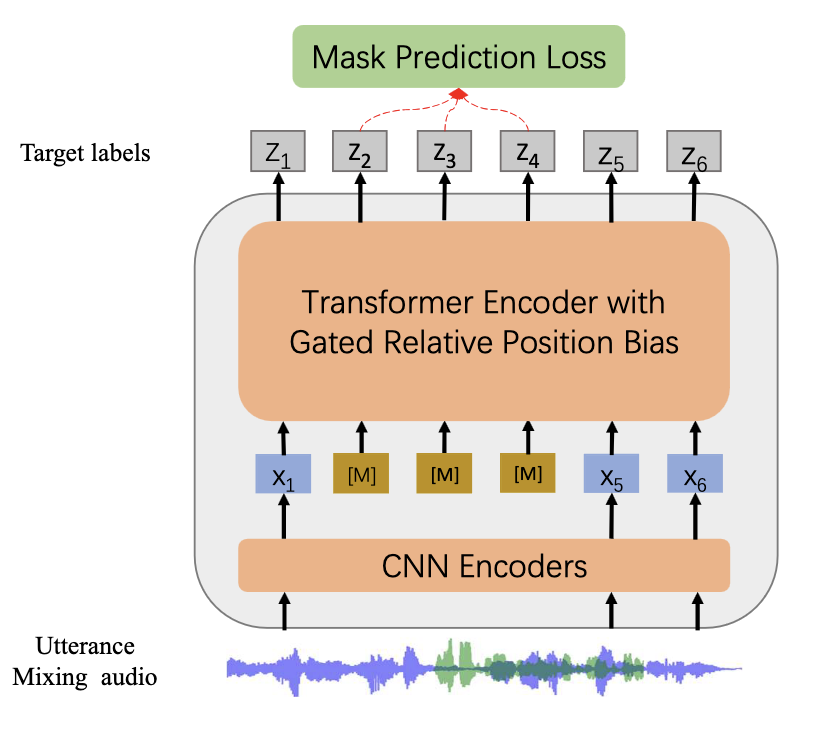


After backbone model is pretrained, we can finetune it to down stream task with singifincatly less amount of training data comparing to training model from scratch. Bellow is an example of WavLM fintuned for ASR task only on 1 hour of labeled data. It's remarkable to see how  __WER=22.8__ is achieved, even without language modelling rescoring.

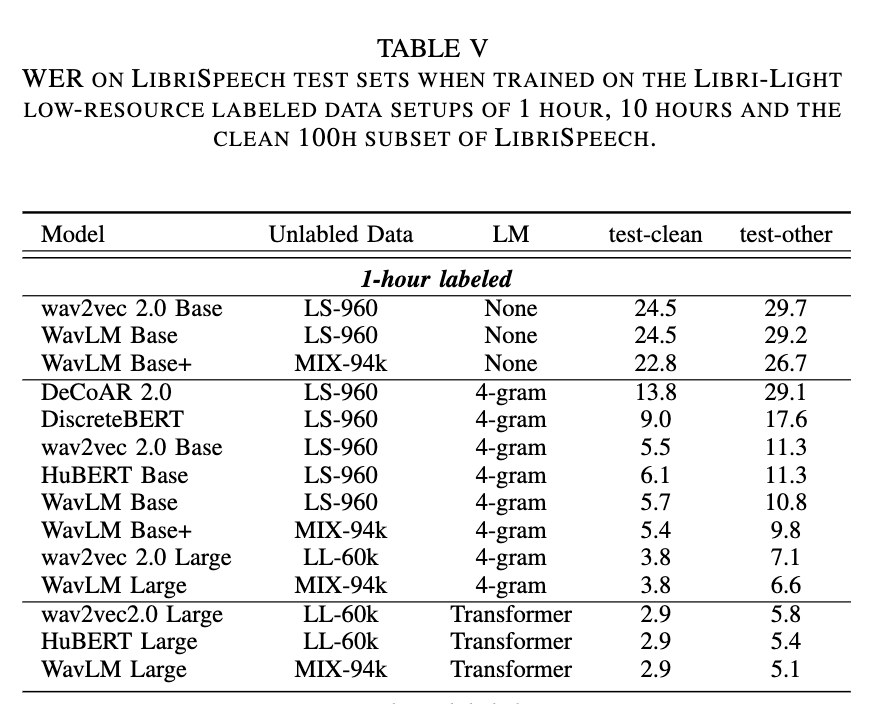


Bellow I'll show how WavLM can be used for speaker verification(SV) task. Where given two utterances $x_{i}$ and $x_{j}$ we want to find out if these utterances were pronounced by the same speaker. To answer this question we extract fixed size speaker embeddings for each utterance and compare them via cossine similarity. $$S(x_i, x_j) \triangleq \cos(\theta) = \frac{e_i \cdot e_j}{|e_i||e_j|} $$
High similarity score indicates that utterances are pronounced by the same speaker. Typicaly we use threshold values to specify a decision boundary for the similarity measure, though these thresholds are dataset dependent.

In [30]:
ref_waveforms = []
for itm in random_samples:
    wav, sr = sf.read(itm['audio_filepath'], dtype='float32')
    ref_waveforms.append(torch.tensor(wav))

gen_waveforms = []
for itm in gen_audio:
    itm_resampled = torchaudio.functional.resample(torch.tensor(itm), 24000, 16000)
    gen_waveforms.append(itm_resampled)

In [31]:
from transformers import AutoFeatureExtractor, WavLMForXVector
from datasets import load_dataset

In [32]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus-sv")
model = WavLMForXVector.from_pretrained("microsoft/wavlm-base-plus-sv")

[NeMo W 2024-05-21 23:06:03 nemo_logging:349] /home/taras/repos/deep-learning-for-audio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
      warnings.warn(
    
Some weights of the model checkpoint at microsoft/wavlm-base-plus-sv were not used when initializing WavLMForXVector: ['wavlm.encoder.pos_conv_embed.conv.weight_g', 'wavlm.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification 

In [33]:
def extract_embedding(wav_tensor):
    with torch.no_grad():
        embeddings = model(wav_tensor.unsqueeze(0)).embeddings
    # embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
    return embeddings

ref_embs = []
for itm in ref_waveforms:
    ref_embs.append(extract_embedding(itm))

gen_embs = []
for itm in gen_waveforms:
    gen_embs.append(extract_embedding(itm))

In [34]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
print("Real vs Synthetic similarity scores")
for ref_emb, gen_emb in zip(ref_embs, gen_embs):
    similarity = cosine_sim(ref_emb, gen_emb)
    print(f"{similarity.item():.3f}")

Real vs Synthetic similarity scores
0.951
0.932
0.770
0.952
0.961
0.936
0.973
0.981


In [35]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
print("Real vs Synthetic similarity scores")
for ref_emb, gen_emb in zip(ref_embs, gen_embs):
    similarity = cosine_sim(ref_emb, gen_emb)
    print(f"{similarity.item():.3f}")

Real vs Synthetic similarity scores
0.951
0.932
0.770
0.952
0.961
0.936
0.973
0.981


In [36]:
# Cosine similarity between two arbitrary speakers
ref_sim = cosine_sim(ref_embs[0], ref_embs[1])
print(ref_sim)
# Cosine similarity between two arbitrary speakers
gen_sim = cosine_sim(gen_embs[0], gen_embs[1])
print(gen_sim)

tensor([0.5926])
tensor([0.5988])
